In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from global_land_mask import globe

In [39]:
enn = np.arange(0,174)

In [40]:

for en in enn:
    for i in ['U10', 'PSL', 'T850','TS']:
        d_path = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.'+f'{en:03d}'+'/atm/hist/cc_PPE_250_ensemble_PD.'+f'{en:03d}'+'.h0.'+str(i)+'.nc'
        data =xr.open_dataset(d_path)
        
        if en == 0:
            lon  = data.variables['lon'][:]  #(lon: 288) [0.0, 1.25, 2.5, ... 356.25, 357.5, 358.75]
            lat  = data.variables['lat'][:]  #(lat: 192) [-90.0 , -89.057592, -88.115183, ... 88.115183,  89.057592, 90.0]
            # time = data.variables['time'][:] #(time: 36)
            
        locals()[str(en)+'_'+i] = data.variables[i][:]

In [43]:
x_lat = np.array(lat)
lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (50)).argmin()])[0]
lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (70)).argmin()])[0]
lat_new  = lat[lat_ind1[0]:lat_ind2[0]]

mask = np.ones((36,len(lat_new),len(lon)))

for a in range(len(lat_new)):
    for b in range(len(lon)):
        if globe.is_land(lat_new[a], lon[b]-180.)==True:
            mask[0:35,a,b] = 0

for en in enn:
    for i in ['U10', 'PSL', 'T850','TS']: #
        tmp  = locals()[str(en)+'_'+i]
        tmp2 = tmp[:,lat_ind1[0]:lat_ind2[0],:]
        locals()['MID'+i+'_'+str(en)] = np.multiply(mask,tmp2)
        

        

In [44]:
#####Constants
Cp = 1004           #J/kg/K
Rd = 287            #J/kg/K

In [45]:
for en in enn:
    locals()['theta_850_'+str(en)] = np.multiply(locals()['MIDT850_'+str(en)],(np.divide(locals()['MIDPSL_'+str(en)],85000))**(Rd/Cp))

In [46]:
for en in enn:
    locals()['M_'+str(en)]   = np.array(np.subtract(locals()['MIDTS_'+str(en)],locals()['theta_850_'+str(en)])).reshape(-1)
    locals()['U10_'+str(en)] = np.array(locals()['MIDU10_'+str(en)]).reshape(-1)

In [8]:
from scipy import stats
from skmisc.loess import loess
for en in enn:
    bin_means, bin_edges, binnumber = stats.binned_statistic(locals()['M_'+str(en)], locals()['U10_'+str(en)], 'mean', bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    x = np.array(bin_centers[:])
    y = np.array(bin_means[:])
    ind = np.argsort(x)
    xx = np.sort(x)
    yy = y[ind]

    l = loess(xx,yy)
    l.fit()
    pred = l.predict(xx, stderror=True)
    conf = pred.confidence()

    locals()['lowess_'+str(en)] = pred.values
    ll = conf.lower
    ul = conf.upper
    locals()['xx_'+str(en)] = xx

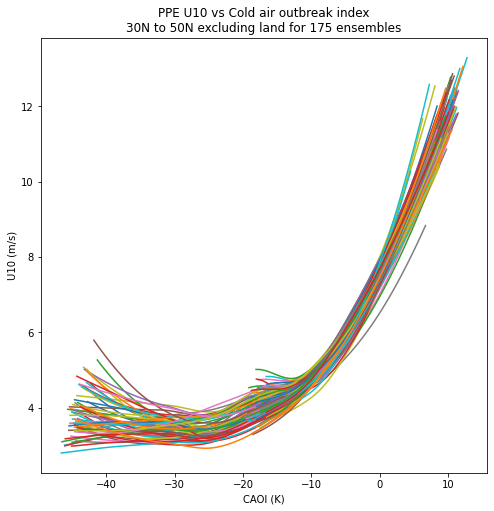

In [37]:
fig= plt.figure(figsize=(8, 8))
for en in enn:
    plt.plot(locals()['xx_'+str(en)], locals()['lowess_'+str(en)], label='ensemble = '+str(en))
    
plt.title('PPE U10 vs Cold air outbreak index\n30N to 50N excluding land for 175 ensembles')
plt.ylabel('U10 (m/s)')
plt.xlabel('CAOI (K)')
plt.savefig('/glade/u/home/geethma/link/GCMres/ppeU10vsMwithMACLWP.png')
# plt.legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

<ipython-input-53-879615ffb076>:21: UserWarning: No contour levels were found within the data range.
  f = plt.contour(x_lon[lon_ind1[0]:lon_ind2[0]], x_lat[lat_ind1[0]:lat_ind2[0]], cao,
<ipython-input-53-879615ffb076>:21: UserWarning: No contour levels were found within the data range.
  f = plt.contour(x_lon[lon_ind1[0]:lon_ind2[0]], x_lat[lat_ind1[0]:lat_ind2[0]], cao,
<ipython-input-53-879615ffb076>:21: UserWarning: No contour levels were found within the data range.
  f = plt.contour(x_lon[lon_ind1[0]:lon_ind2[0]], x_lat[lat_ind1[0]:lat_ind2[0]], cao,


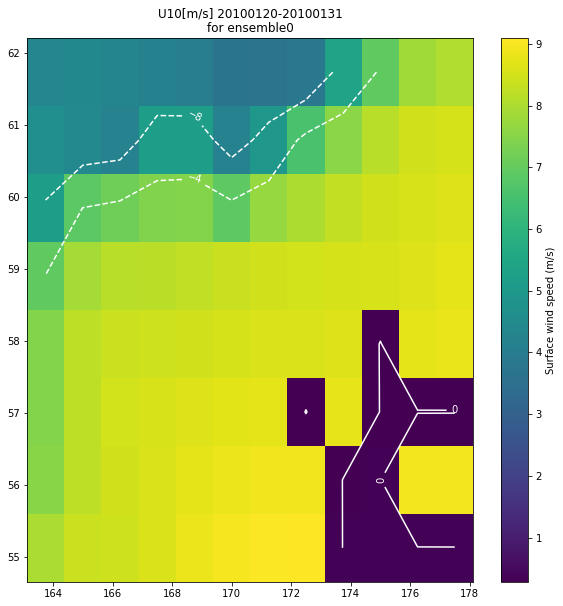

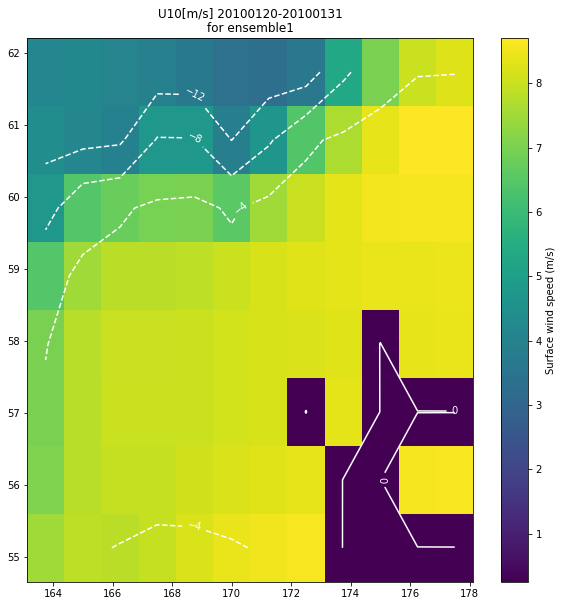

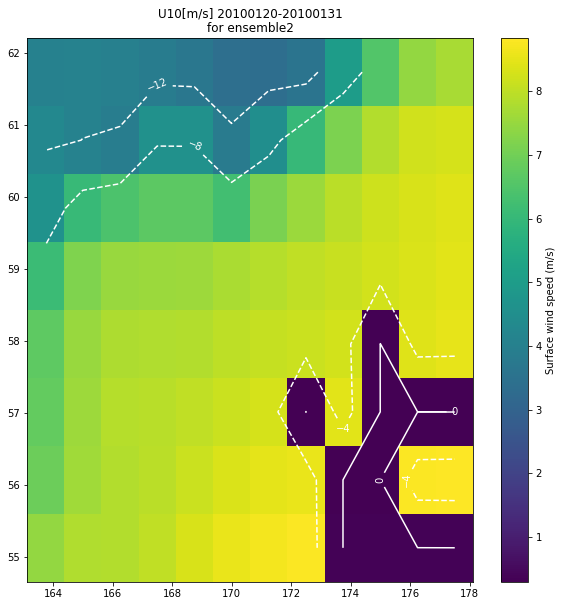

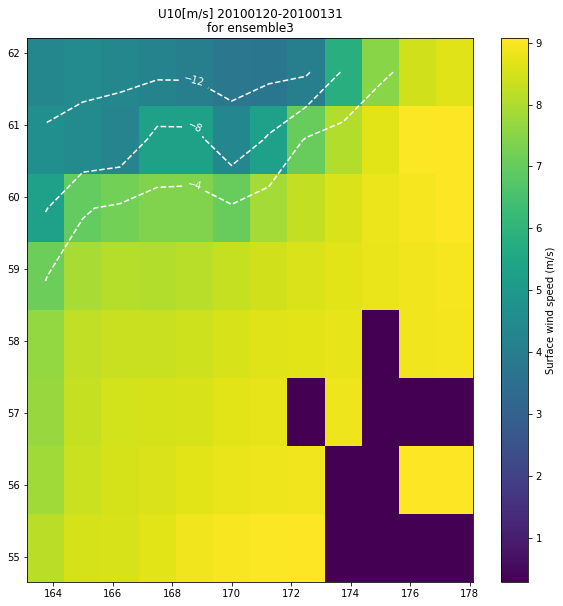

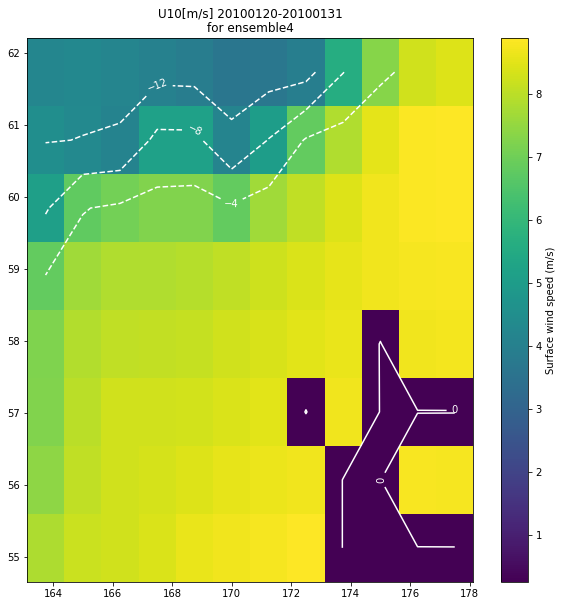

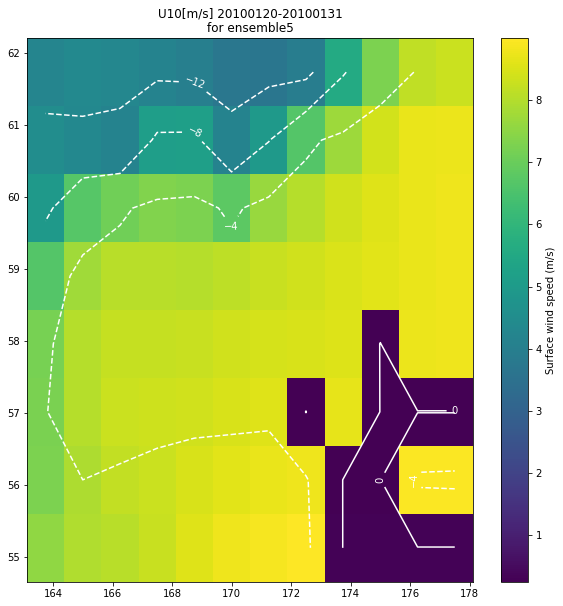

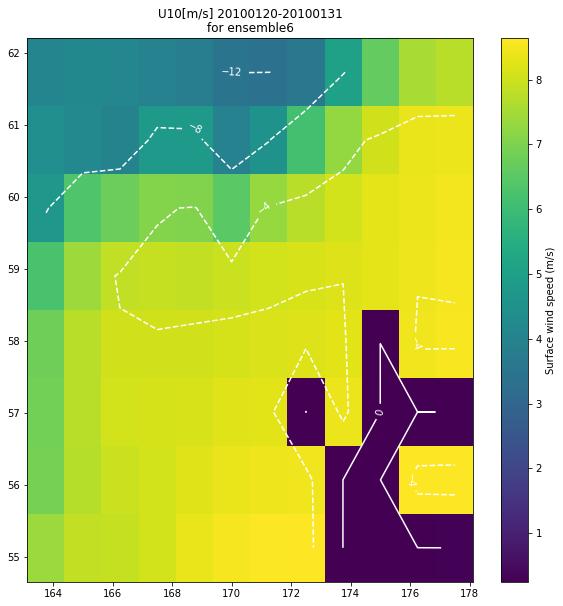

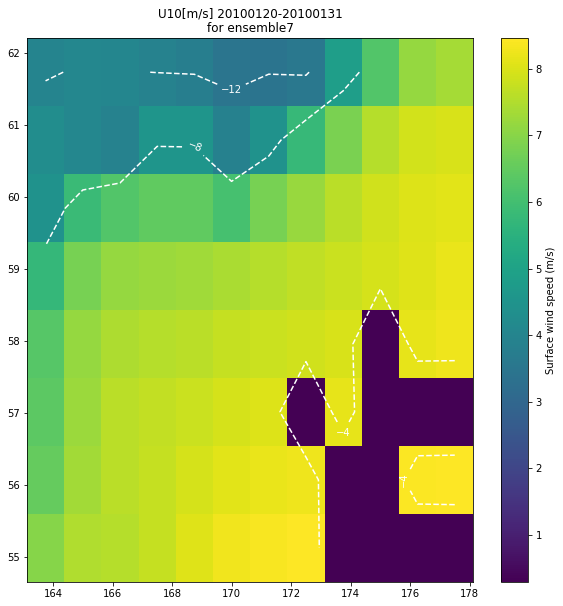

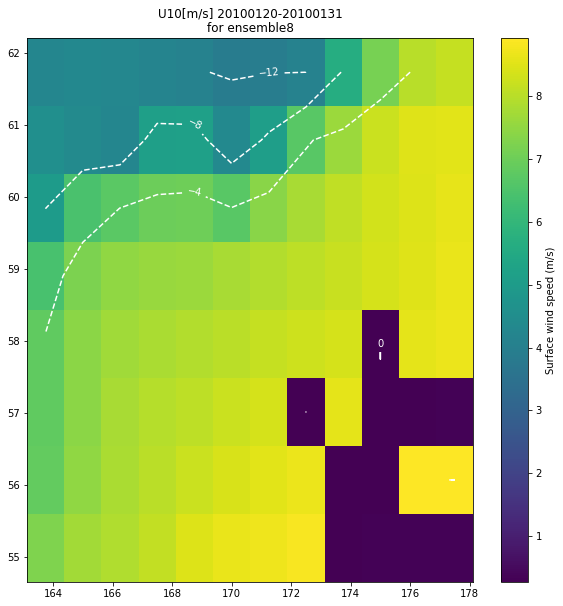

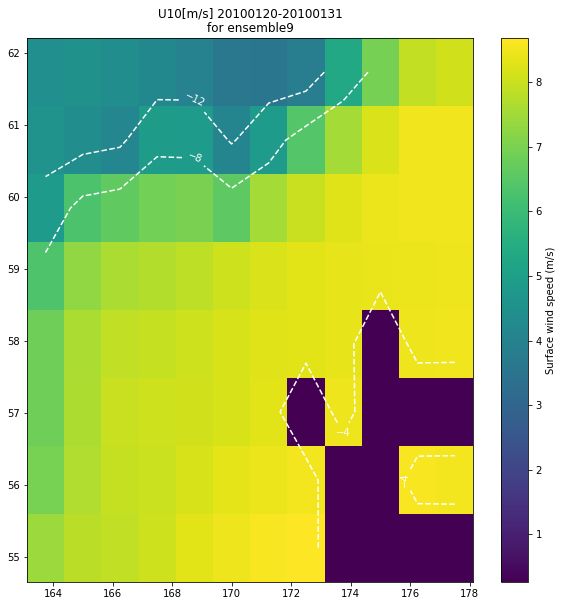

In [53]:
x_lat = np.array(lat_new)
lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (55)).argmin()])[0]
lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (63)).argmin()])[0]    

x_lon = np.array(lon)
lon_ind1 = np.where(x_lon == x_lon.flat[np.abs(x_lon - (164)).argmin()])[0]
lon_ind2 = np.where(x_lon == x_lon.flat[np.abs(x_lon - (179)).argmin()])[0]

for en in range(0,10):
    x_sfcWind = locals()['MIDU10_'+str(en)]
    m_sfcWind = x_sfcWind[:,lat_ind1[0]:lat_ind2[0],lon_ind1[0]:lon_ind2[0]]

    x_M = np.subtract(locals()['MIDTS_'+str(en)],locals()['theta_850_'+str(en)])
    m_M = x_M[:,lat_ind1[0]:lat_ind2[0],lon_ind1[0]:lon_ind2[0]]
    
    cao = np.mean(m_M,axis=0)
    sw  = np.mean(m_sfcWind,axis=0)
    
    fig = plt.figure(figsize=(10,10))
    scatter = plt.pcolormesh(x_lon[lon_ind1[0]:lon_ind2[0]], x_lat[lat_ind1[0]:lat_ind2[0]],sw)
    f = plt.contour(x_lon[lon_ind1[0]:lon_ind2[0]], x_lat[lat_ind1[0]:lat_ind2[0]], cao,
                    5,colors='white',levels=[0,4,8,12],linestyles='-')
    g = plt.contour(x_lon[lon_ind1[0]:lon_ind2[0]], x_lat[lat_ind1[0]:lat_ind2[0]], cao,
                    5,colors='white',levels=[-12,-8,-4],linestyles='--')
    cbar = plt.colorbar(scatter)
    cbar.ax.set_ylabel('Surface wind speed (m/s)')
    plt.clabel(f, inline=True, fontsize=10)
    plt.clabel(g, inline=True, fontsize=10)
    plt.title('U10[m/s] 20100120-20100131\nfor ensemble'+str(en))
    # plt.xticks(np.arange(-16, 0, step=2))
    # plt.yticks(np.arange(55, 63, step=1))
    plt.savefig('/glade/u/home/geethma/link/GCMres/ppeU10'+str(en)+'.png')

In [51]:
lat_ind2

array([13])

In [20]:
from skmisc.loess import loess
x = np.array(bin_centers[:])
y = np.array(bin_means[:])
ind = np.argsort(x)
xx = np.sort(x)
yy = y[ind]

l = loess(xx,yy)
l.fit()
pred = l.predict(xx, stderror=True)
conf = pred.confidence()

lowess = pred.values
ll = conf.lower
ul = conf.upper

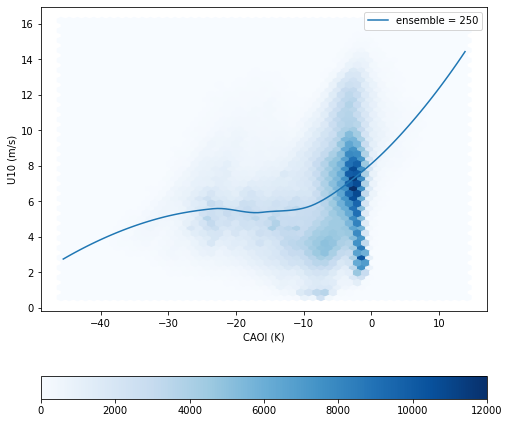

In [22]:
fig= plt.figure(figsize=(8, 8))
hb = plt.hexbin(m, u, gridsize=50, cmap='Blues')
# plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
plt.ylabel('U10 (m/s)')
plt.xlabel('CAOI (K)')
plt.plot(xx, lowess, label='ensemble = 250')
cb = fig.colorbar(hb, orientation='horizontal')
# cb.set_label('count of of cygnss and amsr2 winds\ncollacated within 30 mins')
# plt.plot(bin_centers[:], bin_means[:], 'r.', label='binned wind data')
# plt.fill_between(xx,ll,ul,alpha=.33)
plt.legend()